In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import tree, ensemble

%matplotlib inline

## Extract information

In [2]:
with open('ignored_assets/train.json','r') as f:
    train_dict = json.loads(f.read())

with open('ignored_assets/test.json','r') as f:
    test_dict = json.loads(f.read())

In [3]:
print 'Number of samples: ', len(train_dict)

Number of samples:  1000


In [4]:
traindf = pd.DataFrame()
for s, sample in enumerate(train_dict):
    for m,_ in enumerate(sample):
        sample[m]['SAMPLE_NO'] = s
        sample[m]['TIME'] = pd.to_datetime(sample[m]['TIME'])
        # time since first observation
        sample[m]['TIME_FROM_START'] = sample[m]['TIME'] - sample[0]['TIME']
    traindf = pd.concat((traindf,pd.DataFrame(sample)), ignore_index= True)
    
testdf = pd.DataFrame()
for s, sample in enumerate(test_dict):
    for m,_ in enumerate(sample):
        sample[m]['SAMPLE_NO'] = s
        sample[m]['TIME'] = pd.to_datetime(sample[m]['TIME'])
        # time since first observation
        sample[m]['TIME_FROM_START'] = sample[m]['TIME'] - sample[0]['TIME']
    testdf = pd.concat((testdf,pd.DataFrame(sample)), ignore_index= True)

In [5]:
traindf.head()

,LABEL,SAMPLE_NO,SENSOR_A,SENSOR_B,TIME,TIME_FROM_START
0,UNLOAD_SHIP,0,-157,33,2016-01-01 07:04:03.259405,0 days 00:00:00
1,LOAD_TRAIN,0,103,-32,2016-01-04 09:40:37.897263,3 days 02:36:34.637858
2,NOISE,0,77,-20,2016-01-04 21:26:00.897263,3 days 14:21:57.637858
3,DEPART_TRAIN,0,-38,-56,2016-01-05 05:44:02.396489,3 days 22:39:59.137084
4,NOISE,0,49,105,2016-01-06 03:10:44.396489,4 days 20:06:41.137084


## Explore how sensor readings look for each label

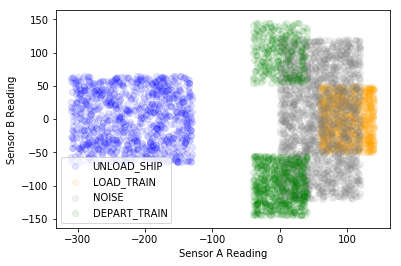

In [6]:
colors = ['blue', 'orange', 'gray', 'green']

for ind,label in enumerate(traindf['LABEL'].unique()):
    mask = traindf['LABEL'] == label
    plt.scatter(traindf[mask]['SENSOR_A'],traindf[mask]['SENSOR_B'], 
                color = colors[ind], label=label, alpha=0.1);

plt.legend();
plt.xlabel('Sensor A Reading');
plt.ylabel('Sensor B Reading');

It seems like the labels are easily separable: they are basically uniform distributions over intervals in A and B. Are there any patterns in time?

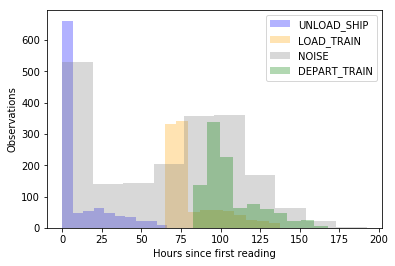

In [7]:
colors = ['blue', 'orange', 'gray', 'green']

for ind,label in enumerate(traindf['LABEL'].unique()):
    mask = traindf['LABEL'] == label
    # based on a
    plt.hist(traindf[mask]['TIME_FROM_START'] / np.timedelta64(1, 'h'), 
                color = colors[ind], label=label, alpha=0.3);

plt.legend();
plt.xlabel('Hours since first reading');
plt.ylabel('Observations');

The noise seems to be spread over time, but there do seem to be two big bulks of noise (around 0 and around 100). Can we visualize that together with the sensor readings?

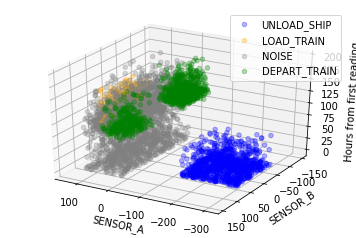

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =[1,2,3,4,5,6,7,8,9,10]
y =[5,6,2,3,13,4,1,2,4,8]
z =[2,3,3,3,5,7,9,11,9,10]


for ind,label in enumerate(traindf['LABEL'].unique()):
    mask = traindf['LABEL'] == label
    # based on a
    ax.scatter(traindf[mask]['SENSOR_A'], 
               traindf[mask]['SENSOR_B'], 
               traindf[mask]['TIME_FROM_START'] / np.timedelta64(1, 'h'), 
               c=colors[ind], marker='o', alpha=0.3, label=label)

ax.set_xlabel('SENSOR_A')
ax.set_ylabel('SENSOR_B')
ax.set_zlabel('Hours from first reading')
ax.legend()

ax.view_init(30, 120)

Noise is distributed throughout time, but has conflicts only through in sensor-space with Load and Depart. Moreover, it seems like each of the relevant labels starts _strictly_ after a certain threshold. 

Let's explore that.

In [9]:
mask = traindf['LABEL'] == 'NOISE'
relevant_stamps = traindf[~mask].pivot(index = 'SAMPLE_NO', columns='LABEL', values='TIME')

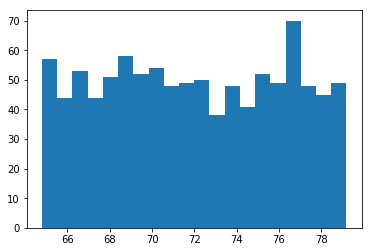

In [10]:
plt.hist((relevant_stamps['LOAD_TRAIN'] - relevant_stamps['UNLOAD_SHIP']) / np.timedelta64(1, 'h'), bins=20);

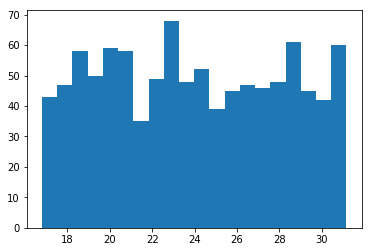

In [11]:
plt.hist((relevant_stamps['DEPART_TRAIN'] - relevant_stamps['LOAD_TRAIN']) / np.timedelta64(1, 'h'), bins=20);

It seems like the time between them are uniformly distributed as well. We can use this to our advantage: sensor readings that occur before this time windows are likely noise.

## Inference

We are going to assume that during inference we have access to all the container history, i.e. inference happens after the container has traveled (vs inference as it travels).

The strategy is going to be as follows:
    1. First, for a given batch, identify the “unload ship” label
    2. Filter the remaining recorded events such that only those happening after “unload ship” remain
    3. Infer “load train” based on their sensor readings and time stamps
    4. Filter the remaining recorded events such that only those happening after “load train” remain
    5. Infer "depart train" from sensor and time readings

### Identify the “unload ship” label

Identifying the “unload ship” label is simple, since in training data it has _no_ overlap with any of the other labels. We will use a simple decision tree, but frankly this could be done with hand written rules.

In [12]:
# create new label indicating whether it is ``unloading ship''
traindf['is_unloading_ship'] = (traindf['LABEL'] == 'UNLOAD_SHIP').astype(np.int64)
testdf['is_unloading_ship'] = (testdf['LABEL'] == 'UNLOAD_SHIP').astype(np.int64)

# create new label indicating whether it is ``loading train''
traindf['is_loading_train'] = (traindf['LABEL'] == 'LOAD_TRAIN').astype(np.int64)
testdf['is_loading_train'] = (testdf['LABEL'] == 'LOAD_TRAIN').astype(np.int64)

# create new label indicating whether it is ``depart train''
traindf['is_depart_train'] = (traindf['LABEL'] == 'DEPART_TRAIN').astype(np.int64)
testdf['is_depart_train'] = (testdf['LABEL'] == 'DEPART_TRAIN').astype(np.int64)

In [13]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(traindf[['SENSOR_A', 'SENSOR_B']], traindf['is_unloading_ship'])

In [14]:
acc = (traindf['is_unloading_ship'] == clf.predict(traindf[['SENSOR_A', 'SENSOR_B']])).sum() / float(len(traindf))

In [15]:
print 'Accuracy: ', acc*100, '%'

Accuracy:  100.0 %


Not surprisingly, since identifying the inital label was easy. How well does it perform on the test set?

In [16]:
acc = (testdf['is_unloading_ship'] == clf.predict(testdf[['SENSOR_A', 'SENSOR_B']])).sum() / float(len(testdf))
print 'Accuracy: ', acc*100, '%'

Accuracy:  100.0 %


Good.

### Filter the remaining recorded events such that only those happening after “unload ship” remain

Now, we need to add extra processing to the remaining data. 

In [17]:
def get_time_from_unloading(x):
    x['TIME_FROM_UNLOADING'] = (x['TIME'] - x[x['is_unloading_ship'] == 1]['TIME'].min()) / np.timedelta64(1, 'h')
    return x

In [18]:
traindf = traindf.groupby('SAMPLE_NO').apply(get_time_from_unloading)
testdf = testdf.groupby('SAMPLE_NO').apply(get_time_from_unloading)

In [19]:
mask1 = traindf['TIME_FROM_UNLOADING'] > 0
mask1_test = testdf['TIME_FROM_UNLOADING'] > 0

Now we can filter and infer.

In [20]:
traindf_post1 = traindf[mask1]
testdf_post1 = testdf[mask1_test]

### Infer “load train” based on their sensor readings and time stamps the events that 

In [21]:
clf2 = ensemble.RandomForestClassifier()
clf2 = clf2.fit(traindf_post1[['SENSOR_A', 'SENSOR_B', 'TIME_FROM_UNLOADING']], traindf_post1['is_loading_train'])

In [24]:
preds = clf2.predict(traindf_post1[['SENSOR_A', 'SENSOR_B', 'TIME_FROM_UNLOADING']])

In [25]:
acc = (traindf_post1['is_loading_train'] == preds).sum() / float(len(traindf_post1))
print 'Train Accuracy: ', acc*100, '%'

Train Accuracy:  99.8587171517 %


In [26]:
preds = clf2.predict(testdf_post1[['SENSOR_A', 'SENSOR_B', 'TIME_FROM_UNLOADING']])
acc = (testdf_post1['is_loading_train'] == preds).sum() / float(len(testdf_post1))
print 'Test Accuracy: ', acc*100, '%'

Test Accuracy:  98.5163204748 %


Not bad. But, I bet we can do better if we obtain the probabilities from each group and choose the one with the highest probability.

In [28]:
def predict_loading_by_group(x):
    # first col is probabilities
    preds = clf2.predict_proba(x[['SENSOR_A', 'SENSOR_B', 'TIME_FROM_UNLOADING']])
    msk = preds[:,0] == preds[:,0].min()
    preds[:,1][msk] = 1
    preds[:,1][~msk] = 0
    x['is_loading_train_pred'] = preds[:,1]
    return x

In [29]:
preds = traindf_post1.groupby('SAMPLE_NO').apply(predict_loading_by_group)['is_loading_train_pred']
acc = (traindf_post1['is_loading_train'] == preds).sum() / float(len(traindf_post1))
print 'Train Accuracy: ', acc*100, '%'

Train Accuracy:  100.0 %


In [30]:
preds = testdf_post1.groupby('SAMPLE_NO').apply(predict_loading_by_group)['is_loading_train_pred']
acc = (testdf_post1['is_loading_train'] == preds).sum() / float(len(testdf_post1))
print 'Test Accuracy: ', acc*100, '%'

Test Accuracy:  98.5163204748 %


Significant improvement.

### Filter the remaining recorded events such that only those happening after “load train” remain

In [31]:
def get_time_from_loading(x):
    x['TIME_FROM_LOADING'] = (x['TIME'] - x[x['is_loading_train'] == 1]['TIME'].min()) / np.timedelta64(1, 'h')
    return x

In [32]:
traindf = traindf.groupby('SAMPLE_NO').apply(get_time_from_loading)
testdf = testdf.groupby('SAMPLE_NO').apply(get_time_from_loading)

In [33]:
mask2 = traindf['TIME_FROM_LOADING'] > 0
mask2_test = testdf['TIME_FROM_LOADING'] > 0

In [34]:
traindf_post2 = traindf[mask2]
testdf_post2 = testdf[mask2_test]

### Infer "depart train" from sensor and time readings

In [35]:
clf3 = ensemble.RandomForestClassifier()
clf3 = clf3.fit(traindf_post2[['SENSOR_A', 'SENSOR_B', 'TIME_FROM_LOADING']], traindf_post2['is_depart_train'])

In [36]:
preds = clf3.predict(traindf_post2[['SENSOR_A', 'SENSOR_B', 'TIME_FROM_LOADING']])
acc = (traindf_post2['is_depart_train'] == preds).sum() / float(len(traindf_post2))
print 'Train Accuracy: ', acc*100, '%'

Train Accuracy:  99.7524752475 %


In [37]:
preds = clf3.predict(testdf_post2[['SENSOR_A', 'SENSOR_B', 'TIME_FROM_LOADING']])
acc = (testdf_post2['is_depart_train'] == preds).sum() / float(len(testdf_post2))
print 'Test Accuracy: ', acc*100, '%'

Test Accuracy:  94.1489361702 %


In [38]:
def predict_depart_by_group(x):
    # first col is probabilities
    preds = clf3.predict_proba(x[['SENSOR_A', 'SENSOR_B', 'TIME_FROM_LOADING']])
    msk = preds[:,0] == preds[:,0].min()
    preds[:,1][msk] = 1
    preds[:,1][~msk] = 0
    x['is_depart_train_pred'] = preds[:,1]
    return x

In [39]:
preds = traindf_post2.groupby('SAMPLE_NO').apply(predict_depart_by_group)['is_depart_train_pred']
acc = (traindf_post2['is_depart_train'] == preds).sum() / float(len(traindf_post2))
print 'Train Accuracy: ', acc*100, '%'

Train Accuracy:  100.0 %


In [40]:
preds = testdf_post2.groupby('SAMPLE_NO').apply(predict_depart_by_group)['is_depart_train_pred']
acc = (testdf_post2['is_depart_train'] == preds).sum() / float(len(testdf_post2))
print 'Train Accuracy: ', acc*100, '%'

Train Accuracy:  96.2765957447 %


As before, the increase in accuracy is significant. 

## Putting it all together

Now we want to put all of this together in a single function and make inference on the set.

In [41]:
def predict_unloadingship_by_group(x):
    # first col is probabilities
    preds = clf.predict_proba(x[['SENSOR_A', 'SENSOR_B']])
    msk = preds[:,0] == preds[:,0].min()
    preds[:,1][msk] = 1
    preds[:,1][~msk] = 0
    x['is_unloading_ship_pred'] = preds[:,1]
    return x

def predict_loading_by_group(x):
    # first col is probabilities
    preds = clf2.predict_proba(x[['SENSOR_A', 'SENSOR_B', 'TIME_FROM_UNLOADING']])
    msk = preds[:,0] == preds[:,0].min()
    preds[:,1][msk] = 1
    preds[:,1][~msk] = 0
    x['is_loading_train_pred'] = preds[:,1]
    return x

def predict_depart_by_group(x):
    # first col is probabilities
    preds = clf3.predict_proba(x[['SENSOR_A', 'SENSOR_B', 'TIME_FROM_LOADING']])
    msk = preds[:,0] == preds[:,0].min()
    preds[:,1][msk] = 1
    preds[:,1][~msk] = 0
    x['is_depart_train_pred'] = preds[:,1]
    return x

def get_time_from_unloading(x):
    x['TIME_FROM_UNLOADING'] = (x['TIME'] - x[x['is_unloading_ship_pred'] == 1]['TIME'].min()) / np.timedelta64(1, 'h')
    return x

def get_time_from_loading(x):
    x['TIME_FROM_LOADING'] = (x['TIME'] - x[x['is_loading_train_pred'] == 1]['TIME'].min()) / np.timedelta64(1, 'h')
    return x

In [42]:
# functions for loading data
def load_data(path):
    with open(path,'r') as f:
        obs_dict = json.loads(f.read())
    obsdf = pd.DataFrame()
    for s, sample in enumerate(obs_dict):
        for m,_ in enumerate(sample):
            sample[m]['SAMPLE_NO'] = s
            sample[m]['TIME'] = pd.to_datetime(sample[m]['TIME'])
            # time since first observation
            sample[m]['TIME_FROM_START'] = sample[m]['TIME'] - sample[0]['TIME']
        obsdf = pd.concat((obsdf,pd.DataFrame(sample)), ignore_index= True)
    return obsdf

In [43]:
def predict_labels(obsdf):
    '''
    Labels each recorded event. Assumes data was loaded with "load_data" function.
    '''
    # default
    obsdf['LABEL_PRED'] = np.nan
    # predict unload
    obsdf = obsdf.groupby('SAMPLE_NO').apply(predict_unloadingship_by_group)
    msk = obsdf['is_unloading_ship_pred'] == 1
    obsdf['LABEL_PRED'].loc[msk] = 'UNLOAD_SHIP'
    # predict load
    obsdf = obsdf.groupby('SAMPLE_NO').apply(get_time_from_unloading)
    obsdf = obsdf.groupby('SAMPLE_NO').apply(predict_loading_by_group)
    msk = obsdf['is_loading_train_pred'] == 1
    obsdf['LABEL_PRED'].loc[msk] = 'LOAD_TRAIN'
    # predict depart
    obsdf = obsdf.groupby('SAMPLE_NO').apply(get_time_from_loading)
    obsdf = obsdf.groupby('SAMPLE_NO').apply(predict_depart_by_group)
    msk = obsdf['is_depart_train_pred'] == 1
    obsdf['LABEL_PRED'].loc[msk] = 'DEPART_TRAIN'
    # label noise
    msk = (~obsdf['is_unloading_ship_pred'].astype(bool)) & (~obsdf['is_loading_train_pred'].astype(bool)) & (~obsdf['is_depart_train_pred'].astype(bool))
    obsdf['LABEL_PRED'].loc[msk] = 'NOISE'
    
    return obsdf
    

In [44]:
train2 = load_data('ignored_assets/train.json')

In [45]:
train2 = predict_labels(train2)

/Users/ramoniglesias/development/sensing-ship/venv/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
acc = (train2['LABEL'] == train2['LABEL_PRED']).sum() / float(train2.shape[0])
print 'Train Accuracy: ', acc * 100, '%'

Train Accuracy:  100.0 %


In [47]:
test2 = load_data('ignored_assets/test.json')
test2 = predict_labels(test2)

In [48]:
acc = (test2['LABEL'] == test2['LABEL_PRED']).sum() / float(test2.shape[0])
print 'Train Accuracy: ', acc * 100, '%'

Train Accuracy:  97.7505112474 %


Not bad!

## Potential Improvements

The current approach seems to work very well. However, it is not surprising: the data was clearly artificially generated with very clear distributions. We could do better on it by tweaking the classifiers or leveraging the knowledge that each _relevant_ event happens exactly ones in each sample. 

Additionally, we rely on corret labeling of earlier events to predict the next relevant event. Under realistic conditions, it might be necessary to keep track of our classification uncertainty (taking a more Bayesian approach, for example). The end results would give labeling probabilities to each recorded event.